(example_Ni(110))=

# Example System: Ni(110) using the ASE interface

In this example we demonstrate how to use the ViPErLEED Python package {term}`tleedm` and the {ref}`atomic simulation environment (ASE) interface<ase>` with the example of a Ni(110) surface. 
With ASE, we can easily create surface strucutrues for a simple Ni(110)-{math}`(1\times1)` bulk termination and a {math}`(1\times2)` a missing-row reconstruction.

We then set up a ViPErLEED calculation directly from these ASE atoms objects without writing out a {ref}`POSCAR<poscar>` file.
This yields theoretical LEED {math}`I(V)` curves, which we can easily visulaize and between which we can calculate an R-factor.


```{tip}

If this is your first time running ViPErLEED, make sure to first follow the {ref}`installation instructions<installation>`.
For details on how to execute ViPErLEED on your system, see the {ref}`How To Run section<how_to_run>`.

For an example on how to run ViPErLEED without the ASE interface see e.g. {ref}`this tutorial<example_ag_100>`.
```

In [1]:
# ASE imports - TODO: may not need all
import ase
import ase.build
from ase.visualize.plot import plot_atoms
import ase.io

# @Michele TODO: this mess will change to:
# import viperleed
# once the package is reorganized...
import os
import sys
vpr_path = "../../../../../"
if os.path.abspath(vpr_path) not in sys.path:
    sys.path.append(os.path.abspath(vpr_path))

import viperleed
from viperleed.viperleed_from_ase import *
import viperleed.tleedmlib.classes.slab
from tleedmlib.files.poscar import readPOSCAR

import matplotlib.pyplot as plt
%matplotlib inline

## Creating the Ni surfaces

The first step is to create the Ni(110) surface structure as an ASE atoms.atoms object.
We can use the convenient surface creations tools contained in the [ase.build module](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html).
Since Ni is an {term}`fcc` metal, we can use the ``ase.build.fcc(110)`` method.
ASE will automatically recognize ``Ni`` as an element label and use the correct experimental lattice constant for the structure.

We first create the bulk-truncated structure with 6 layers.
For our visualization below, we also add 3 A of vaccuum above and below the slab.

In [2]:
ni_1x1_cell = ase.build.fcc110('Ni', size=(1,1,6), vacuum=3)

Using the matploib and the ase.visualize module we can take a look at the atoms object:

In [3]:
def show_slab_along_z_y(atoms):
    plt.figure()
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

    plot_atoms(atoms, axarr[0], rotation=('0x,0y,0z'))
    plot_atoms(atoms, axarr[1], rotation=('-90x,-90y,0z'))

    axarr[0].set_title("View along $z$ (towards bulk)")
    axarr[1].set_title("View along $y$")

    axarr[0].set_xlabel("X-axis, [$\mathrm{\AA}$]")
    axarr[0].set_ylabel("Y-axis, [$\mathrm{\AA}$]")
    axarr[1].set_xlabel("Y-axis, [$\mathrm{\AA}$]")
    axarr[1].set_ylabel("Z-axis, [$\mathrm{\AA}$]")

    fig.show()

/var/folders/fv/bxt6sbpd2sn0kbhr1rksclxc0000gp/T/ipykernel_72919/3533327454.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

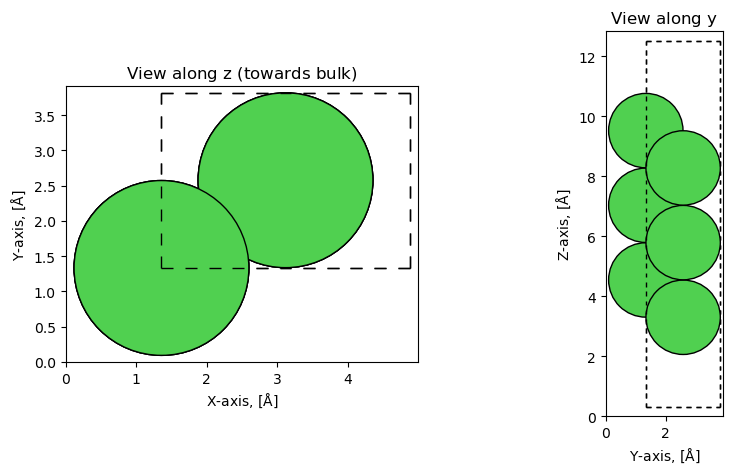

In [4]:
show_slab_along_z_y(ni_1x1_cell)

The Ni atoms are depicted as grey spheres and the unit cell (periodic boundary conditions along $x$ and $y$) is indicated with a dashed line.
The surface, as per {ref}`ViPErLEED convention<conventions>` is facing upwards, towards higher $z$.

To create the missing row reconstruction, we first make a slab with a {math}`(1\times2)` supercell and 6 layers.
In the atoms object, the atoms are currently sorted from lowest to highest, which we can double check by listing their positions.

In [5]:
ni_1x2_supercell = ase.build.fcc110('Ni', size=(1,2,6), vacuum=3)

# show fractional coordinates of Ni atoms
ni_1x2_supercell.get_scaled_positions()

array([[0.5       , 0.25      , 0.24544817],
       [0.5       , 0.75      , 0.24544817],
       [0.        , 0.        , 0.3472689 ],
       [0.        , 0.5       , 0.3472689 ],
       [0.5       , 0.25      , 0.44908963],
       [0.5       , 0.75      , 0.44908963],
       [0.        , 0.        , 0.55091037],
       [0.        , 0.5       , 0.55091037],
       [0.5       , 0.25      , 0.6527311 ],
       [0.5       , 0.75      , 0.6527311 ],
       [0.        , 0.        , 0.75455183],
       [0.        , 0.5       , 0.75455183]])

To create the missing row reconstruction, we thus need to remove one of the two atoms in the surface layer.
We simply copy our supercell and create the missing row reconstruction by removing the last atom:

/var/folders/fv/bxt6sbpd2sn0kbhr1rksclxc0000gp/T/ipykernel_72919/3533327454.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

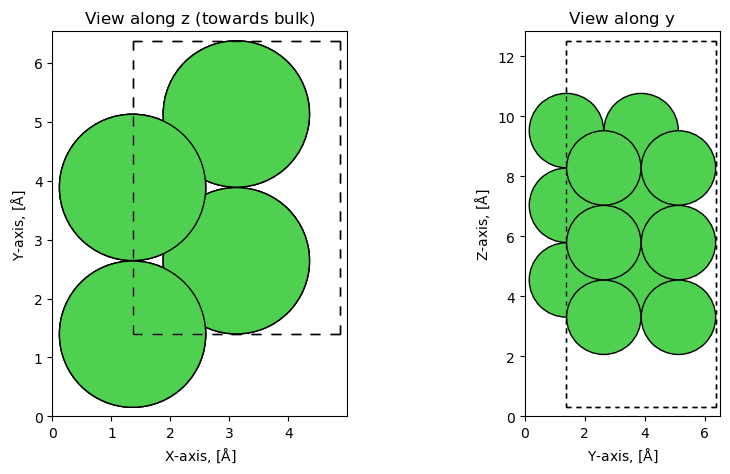

<Figure size 640x480 with 0 Axes>

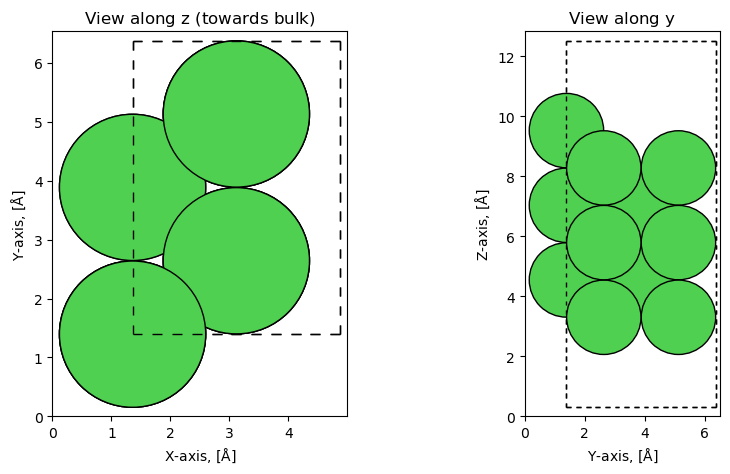

In [6]:
ni_1x2_missing_row = ni_1x2_supercell.copy()
del ni_1x2_missing_row[11] # index starting from 0

show_slab_along_z_y(ni_1x2_supercell) # show the missing row resconstruction
show_slab_along_z_y(ni_1x2_missing_row) # show the missing row resconstruction

## ViPErLEED Input

Now that we have a slab, we can prepare the ViPErLEED calculation.
However, ViPErLEED needs some additional information to run, apart from the input structure.
We generally need to provide multiple input files in a source directory. 
For this example, we create a temporary directory to run the calculation ([Python tempfile module](https://docs.python.org/3/library/tempfile.html)), but you can, of course, also use a persitent path.

In [7]:
import tempfile
from pathlib import Path

bulk_term_dir = Path(tempfile.mkdtemp())
missing_row_dir = Path(tempfile.mkdtemp())

tempdirs = [bulk_term_dir, missing_row_dir]

### Input Files
The ViPErLEED ASE interface allows you to specify a sperate path (argument ``inputs_path``) from which other input files will be copied.
This can be useful for e.g batch processing of test structures with similar settings.

In [8]:
input_path = "../../../_static/example_systems/Ni(110)/"

In our case, we provide two files in the input directory: {ref}`PARAMETERS<parameters>` and `IVBEAMS<ivbeams>`.

#### PARAMETERS

As usual, we provide settings using the {ref}`PARAMETERS file<parameters>`.
In the ViPErLEED ASE interface you can use all parameters available in a typical ViPErLEED run.


```{literalinclude} /_static/example_systems/Ni(110)/PARAMETERS
   :language: console
   :caption: PARAMETERS
```

We don't have a {ref}`POSCAR file`, but we can still use the {ref}`BULK_LIKE_BELOW` parameter, to tell ViPErLEED how to distinguish between the surface and the bulk.
In this example, we can use the bottom two layers as bulk layers, so we can use a value of 0.42 (compare $z$ positions as shown above).

The ASE interface also has one more feature, that we can use here: By leaving out the {SITE_DEF parameter}, we tell ViPErLEED to use the automatic site detection (for details see {ref}`here<aseapi_auto_sites>`).

Since we don't provide a {ref}`VIBROCC file<vibrocin`, we need to specify the parmeters {ref}`T_DEBYE<t_debye>`, {ref}`T_EXPERIMENT<t_experiment>`, and {ref}`VIBR_AMP_SCALE<VIBR_AMP_SCALE>`.

Finally, we need to set the HALTING parameter = 3 TODO


#### IVBEAMS

Since we want to perform a theory-theory comparison and don't have an {ref}`EXPEBEAMS file<expbeams>`, we also need to provide the file {ref}`IVBEAMS<ivbeams>` which specifies for which diffraction beams to generate output spectra.
Here, we use a very simplistic IVBEAMS with just 5 beams:

```{literalinclude} /_static/example_systems/Ni(110)/IVBEAMS
   :language: console
   :caption: IVBEAMS
```

## Running ViPErLEED

We use the Jupyter magic command ``%%caputre`` to suppress the output of the cell (which would otherwise print out the entire content of the {ref}`ViPErLEED log file<log_file>`).

In [9]:
%%capture

refcalc_results = run_from_ase(exec_path=bulk_term_dir,
             inputs_path=input_path,
             ase_object=ni_1x1_cell,
             cut_cell_c_fraction=0.0,
             )

theobeams_supercell, _, _ , v0i_bt = refcalc_results

In [10]:
%%capture

refcalc_results = run_from_ase(exec_path=missing_row_dir,
             inputs_path=input_path,
             ase_object=ni_1x2_missing_row,
             cut_cell_c_fraction=0.0,
             )

theobeams_missing_row, _, _ , v0i_mr = refcalc_results

In [11]:
theobeams_files = [theobeams_supercell, theobeams_missing_row]
is_content = [True, True]
legends = ["($1×1$) Bulk Terminated", "($1×2$) Missing Row"]

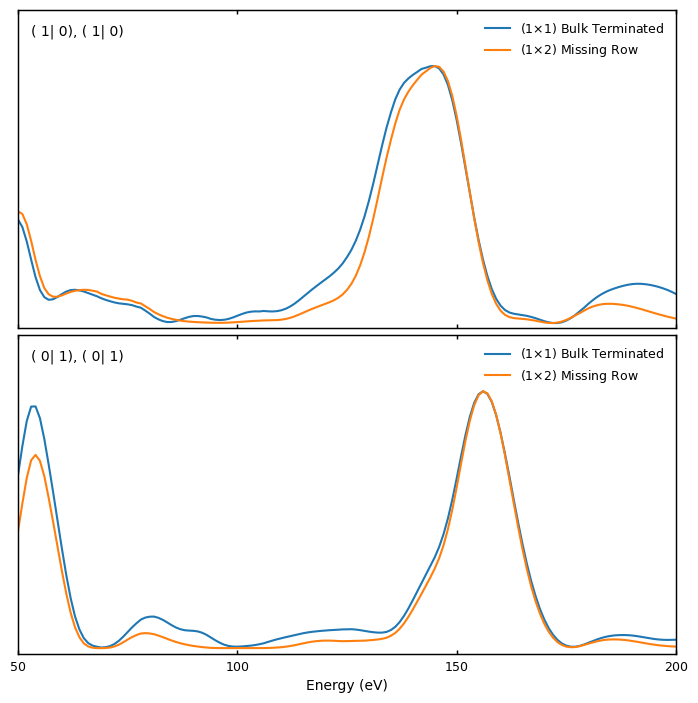

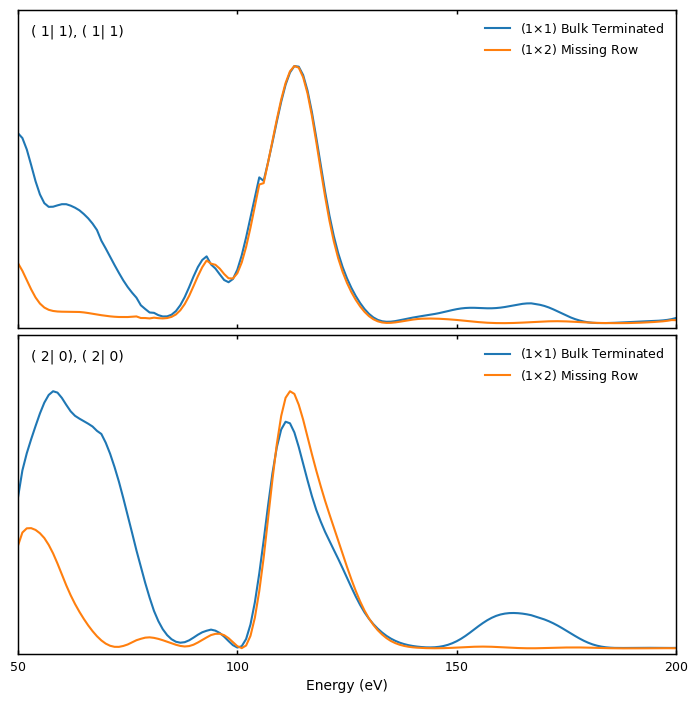

In [12]:
figs = plot_iv_from_csv(beam_file=theobeams_files,
                        beam_file_is_content=is_content,
                        legends=legends)
plt.show(figs)

In [13]:
# make sure V0i is same in both cases
assert v0i_bt == v0i_mr
v0i = v0i_bt

In [14]:
rfactor, v0r = rfactor_from_csv(beams_files=theobeams_files,
                 v0i=v0i_mr,
                 beams_file_is_content=is_content)

print(f"R-factor: {rfactor:.3f}")

R-factor: 0.296


In [15]:
import shutil
#cleanup
for t_dir in tempdirs:
    shutil.rmtree(t_dir)